# 03a - BigQuery ML (BQML) - Logistic Regression For Classification

>**Note:** Formerly named `03a - BigQuery Machine Learning (BQML) - Machine Learning with SQL.ipynb`.  This [link](https://github.com/statmike/vertex-ai-mlops/blob/fd442b458c710a0a7afdc41bae690d2a3282e93c/03a%20-%20BigQuery%20Machine%20Learning%20(BQML)%20-%20Machine%20Learning%20with%20SQL.ipynb) goes to the previous version featured in the video.

In this notebook, BigQuery ML (BQML) is used to create a logistic regression model.

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Video Walkthrough of this notebook:**

Includes conversational walkthrough and more explanatory information than the notebook:

<p align="center" width="100%"><center><a href="https://youtu.be/IcVyP_ZAXmY" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/03a.png" width="40%"></a></center></p>


**Prerequisites:**
-  01 - BigQuery - Table Data Source

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03a_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03a_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'google.com:cbo-mnl'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '03a'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [4]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = 'jonas-ai-experiment'
URI = f"gs://{BUCKET}/{BQ_DATASET}/models/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{EXPERIMENT}_{BQ_DATASET}_{TIMESTAMP}'

---
## This Run

In [6]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: google.com:cbo-mnl.fraud.03a_fraud_20221003095355
The Timestamp Is: 20221003095355


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [8]:
query = f"""
CREATE MODEL `{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
job = bq.query(query = query)
job.result()

In [9]:
(job.ended-job.started).total_seconds()

133.681

Add labels to the model in BigQuery:

In [10]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the iterations from training with [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [11]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.684205,0.684469,0.2,7508
1,0,1,0.646252,0.646556,0.4,9524
2,0,2,0.578601,0.578960,0.8,9069
3,0,3,0.471104,0.471530,1.6,9390
4,0,4,0.334772,0.335257,3.2,9356
5,0,5,0.217272,0.217744,6.4,10446
6,0,6,0.160166,0.160342,12.8,9107
7,0,7,0.123444,0.123306,25.6,7839


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

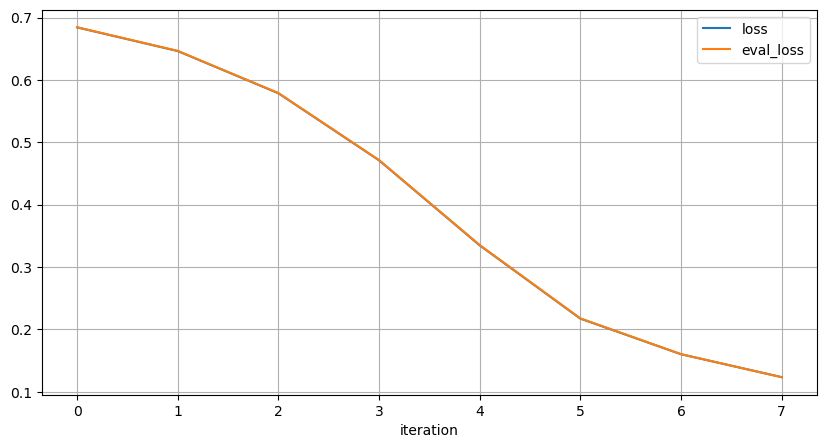

In [12]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [13]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=google.com:cbo-mnl


In [14]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=google.com:cbo-mnl&ws=!1m5!1m4!5m3!1sgoogle.com:cbo-mnl!2sfraud!3s03a_fraud_20221003095355


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [15]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,0.102041,0.923077,0.981431,0.183767,0.139059,0.986646
1,TEST,0.081356,0.941176,0.980935,0.149766,0.121316,0.977919
2,TRAIN,0.073430,0.898936,0.981087,0.135770,0.123444,0.985450


### Confusion Matrix

Review the confusion matrix for each split with [`ML.CONFUSION_MATRIX`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [16]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,222876,4265
1,1,38,338


In [17]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28110,528
1,1,5,60


In [18]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,27994,542
1,1,3,48


### ROC Curve

Retrieve the ROC Curve for each split using [`ML.ROC_CURVE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [19]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.938188e-01,0.957447,0.108708,360,24692,202449,16
1,1.083831e-08,1.000000,1.000000,376,227141,0,0
2,7.475431e-02,0.994681,0.398761,374,90575,136566,2
3,3.593892e-02,0.997340,0.729573,375,165716,61425,1
4,5.604584e-02,0.997340,0.529134,375,120188,106953,1


In [20]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.206337,0.969231,0.098156,63,2811,25827,2
1,0.146033,0.984615,0.168343,64,4821,23817,1
2,0.110929,0.984615,0.248272,64,7110,21528,1
3,0.033797,1.000000,0.759585,65,21753,6885,0
4,0.043729,1.000000,0.649312,65,18595,10043,0


In [21]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.053466,0.980392,0.549271,50,15674,12862,1
1,0.194136,0.980392,0.108495,50,3096,25440,1
2,0.077415,0.980392,0.378995,50,10815,17721,1
3,0.085060,0.980392,0.338905,50,9671,18865,1
4,0.023643,0.980392,0.870024,50,24827,3709,1


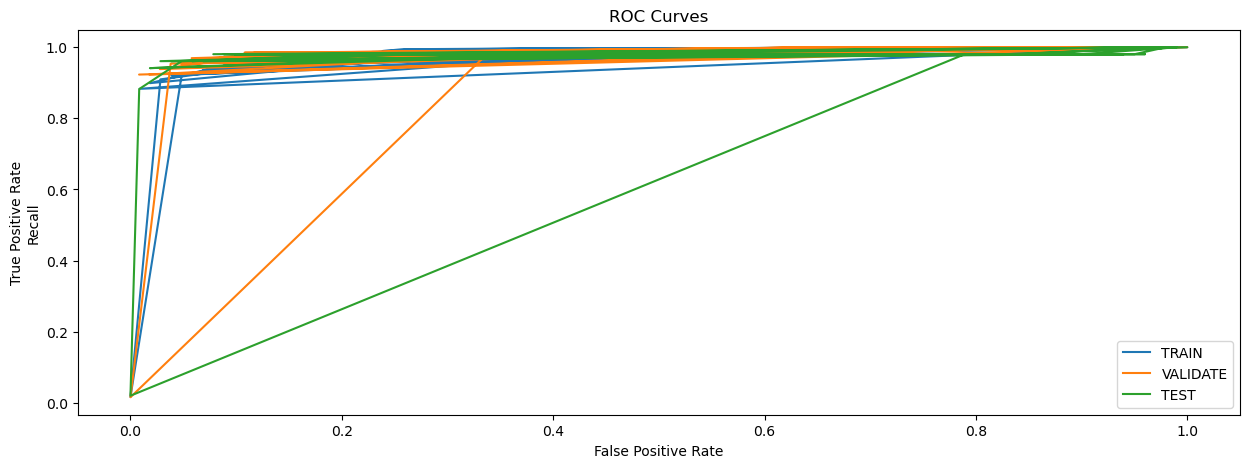

In [22]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with predictions for the test data in the table:

In [23]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [24]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [25]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.20211971481073993}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.06757966789496939}, {'...",TEST
2,0,0,"[{'label': 1, 'prob': 0.07195032997687635}, {'...",TEST
3,0,0,"[{'label': 1, 'prob': 0.3090413595461543}, {'l...",TEST
4,0,0,"[{'label': 1, 'prob': 0.06342774927749067}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [26]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.7978802851892601},
  {'label': 1, 'prob': 0.20211971481073993}]]

---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [27]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [28]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.797880,"[{'feature': 'V12', 'attribution': 1.454715142...",-2.652128,-1.373098,0.0,5043,-0.610353,0.876268,3.134572,...,-0.183132,0.295979,-0.159989,-0.130196,-0.076139,-0.109076,0.0,0,c53a0939-4986-4db8-bf1b-1b8a5d66a495,TEST
1,0,0.932420,"[{'feature': 'V4', 'attribution': 1.1224840793...",-2.652128,-2.624477,0.0,8785,1.153022,0.436133,1.274728,...,0.054247,0.441790,0.144198,0.995412,-0.057928,0.011057,0.0,0,31c6a284-bf4e-4fe1-a6a5-54e814db9049,TEST
2,0,0.928050,"[{'feature': 'V12', 'attribution': -0.30636510...",-2.652128,-2.557109,0.0,47284,1.083086,-0.351338,1.128419,...,0.014244,-0.240059,0.120230,0.618435,0.029500,0.003249,0.0,0,80849f70-e097-4769-ba15-bb77a323de47,TEST
3,0,0.690959,"[{'feature': 'V4', 'attribution': 1.6689737676...",-2.652128,-0.804605,0.0,49582,1.069103,-0.040292,1.437476,...,-0.078798,0.084000,0.487789,0.248265,0.054261,0.019949,0.0,0,3e86637b-a1c9-475d-8a45-75627b3141f0,TEST
4,0,0.936572,"[{'feature': 'V4', 'attribution': 1.6543331103...",-2.652128,-2.692325,0.0,78048,-6.484267,-7.875117,0.680973,...,-0.041943,-0.246966,-0.745300,0.195860,0.166256,-1.216419,0.0,0,8bf45536-66ba-43c0-b1cc-0bf14731dd37,TEST


Create a plot of feature attributions for a single prediction:

In [29]:
explanation = explain.iloc[0]['top_feature_attributions']

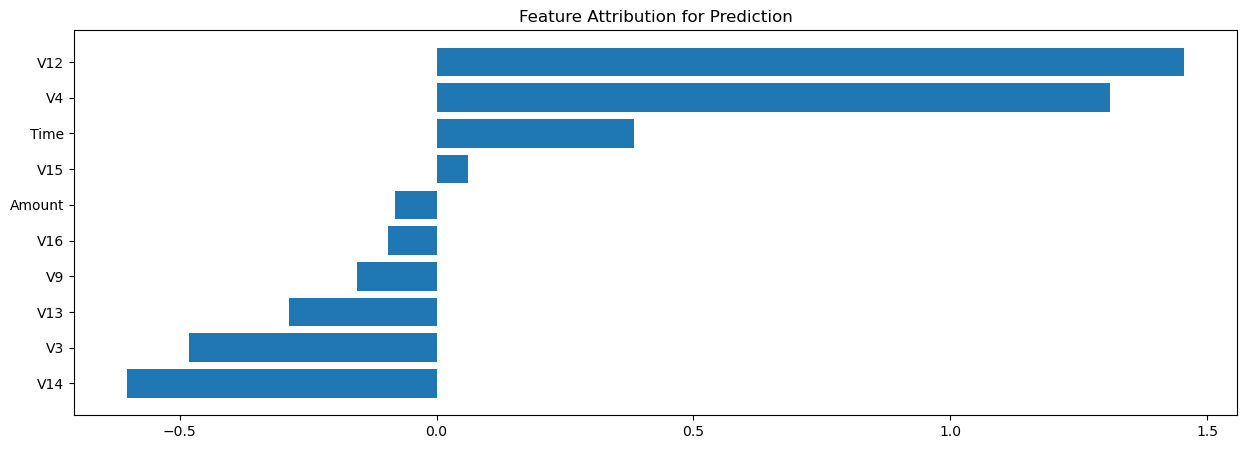

In [30]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [`ML.GLOBAL_EXPLAIN`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [31]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [32]:
gexplain.head()

,feature,attribution
0,V4,0.629891
1,V14,0.484722
2,V12,0.357872
3,V13,0.243563
4,V10,0.216432


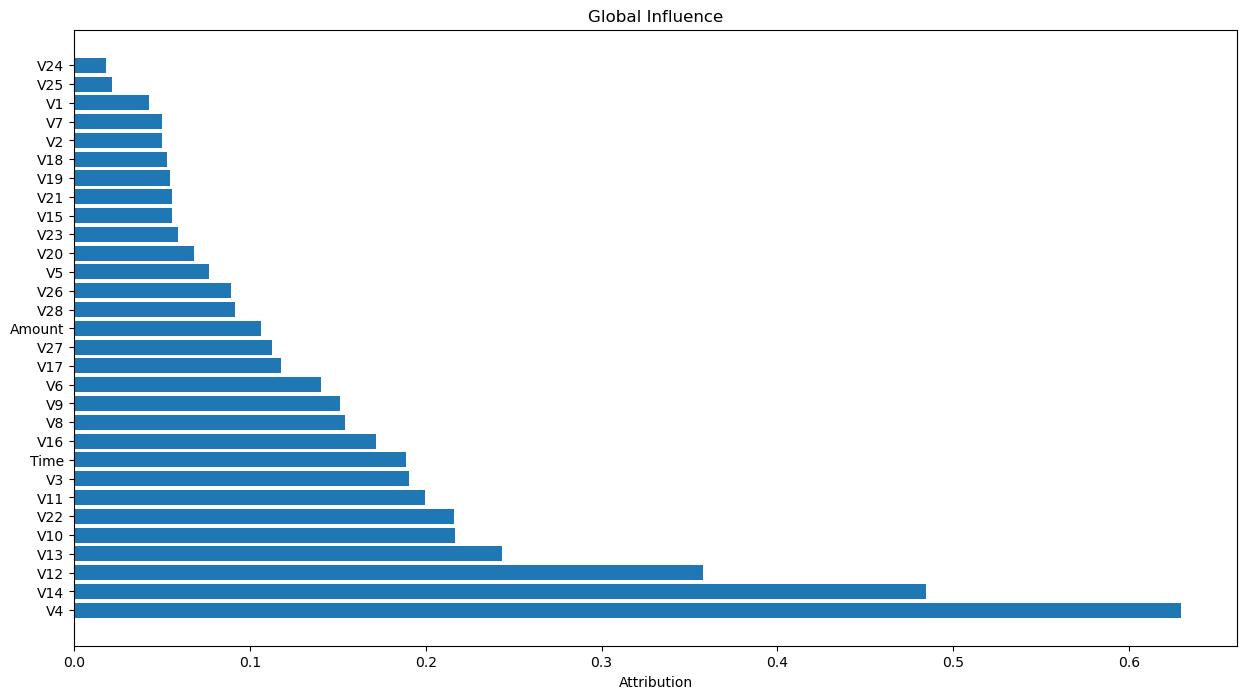

In [33]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [35]:
query = f"""
EXPORT MODEL `{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [36]:
(export.ended - export.started).total_seconds()

21.269

In [37]:
listing = !gsutil ls {URI}/{TIMESTAMP}/model
listing

['gs://jonas-ai-experiment/fraud/models/03/03a/20221003095355/model/',
 'gs://jonas-ai-experiment/fraud/models/03/03a/20221003095355/model/saved_model.pb',
 'gs://jonas-ai-experiment/fraud/models/03/03a/20221003095355/model/variables/']

In [38]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/jonas-ai-experiment/fraud/models/03/03a/20221003095355/model?project=google.com:cbo-mnl


### Detect The Model Types Framework

In [39]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = TensorFlow


Set the `DEPLOY_IMAGE` based on the framework:

In [40]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

### Upload The Model To Vertex AI Model Registry
References:
- Python SDK for [`aiplatform.Model`](https://googleapis.dev/python/aiplatform/latest/aiplatform/services.html#google.cloud.aiplatform.Model)
- Python Client for [`aiplatform.Model`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [41]:
modelmatch = aiplatform.Model.list(filter = f'labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{EXPERIMENT}_{BQ_DATASET}',
        model_id = f'model_{EXPERIMENT}_{BQ_DATASET}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

This is a new model, adding to model registry as version 1
Creating Model
Create Model backing LRO: projects/169853841455/locations/us-central1/models/model_03a_fraud/operations/830956256289095680
Model created. Resource name: projects/169853841455/locations/us-central1/models/6947185055265456128@1
To use this Model in another session:
model = aiplatform.Model('projects/169853841455/locations/us-central1/models/6947185055265456128@1')


In [42]:
model.display_name

'03a_fraud'

In [43]:
model.resource_name

'projects/169853841455/locations/us-central1/models/6947185055265456128'

In [44]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{EXPERIMENT}_{BQ_DATASET}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03a_fraud?project=google.com:cbo-mnl


---
## Online Predictions with Vertex AI Endpoints
Check out the notebook `03Tools - Predictions` to see how to use this model with [online predictions in Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models).

---
## Remove Resources
see notebook "99 - Cleanup"